In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import f1_score
import optuna
import seaborn as sns

In [51]:

GDP_developing = pd.read_csv('GDP_per_capita_developing.csv')
GDP_developed = pd.read_csv('GDP_per_capita_developed.csv')

GDPgrowth_developing = pd.read_csv('GDP_growth_developing.csv', index_col= 0)
GDPgrowth_developing = GDPgrowth_developing.T
GDPgrowth_developed = pd.read_csv('GDP_growth_developed.csv', index_col=0)
GDPgrowth_developed = GDPgrowth_developed.T

CPI_developing = pd.read_csv('CPIdeveloping.csv', index_col= 0)
CPI_developing = CPI_developing.T
CPI_developed = pd.read_csv('CPIdeveloped.csv', index_col= 0)
CPI_developed = CPI_developed.T

start_date = pd.to_datetime('2001-01-01')
quarters_datetime = pd.date_range(start=start_date, periods=len(CPI_developing.index), freq='Q')
CPI_developed['Date_Quarterly'] = quarters_datetime
CPI_developing['Date_Quarterly'] = quarters_datetime


intrate_developing =pd.read_csv('int_rate_developing.csv',index_col = 0)
intrate_developing = intrate_developing.T
intratedeveloping = intrate_developing.rename(columns={np.nan: 'Date'})
intrate_developing['Date_Quarterly'] = quarters_datetime

intrate_developed = pd.read_csv('int_rate_developed.csv', index_col = 0)
intrate_developed = intrate_developed.T
intrate_developed = intrate_developed.rename(columns={np.nan: 'Date'})
intrate_developed['Date_Quarterly'] = quarters_datetime


CAB_developing = pd.read_csv('CABdeveloping.csv', index_col = 0)
CAB_developing = CAB_developing.T

CAB_developed = pd.read_csv('CABdeveloped.csv', index_col = 0)
CAB_developed = CAB_developed.T

unemployment_developing = pd.read_csv('unemployment_developing.csv',index_col= 0 )

unemployment_developed = pd.read_csv('unemployment_developed.csv',index_col= 0 )
print(quarters_datetime)

DatetimeIndex(['2001-03-31', '2001-06-30', '2001-09-30', '2001-12-31',
               '2002-03-31', '2002-06-30', '2002-09-30', '2002-12-31',
               '2003-03-31', '2003-06-30', '2003-09-30', '2003-12-31',
               '2004-03-31', '2004-06-30', '2004-09-30', '2004-12-31',
               '2005-03-31', '2005-06-30', '2005-09-30', '2005-12-31',
               '2006-03-31', '2006-06-30', '2006-09-30', '2006-12-31',
               '2007-03-31', '2007-06-30', '2007-09-30', '2007-12-31',
               '2008-03-31', '2008-06-30', '2008-09-30', '2008-12-31',
               '2009-03-31', '2009-06-30', '2009-09-30', '2009-12-31',
               '2010-03-31', '2010-06-30', '2010-09-30', '2010-12-31',
               '2011-03-31', '2011-06-30', '2011-09-30', '2011-12-31',
               '2012-03-31', '2012-06-30', '2012-09-30', '2012-12-31',
               '2013-03-31', '2013-06-30', '2013-09-30', '2013-12-31',
               '2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31',
      

In [52]:
def quarterly_duplicate(df,quarters_datetime):
    df = df.loc[df.index.repeat(4)].reset_index(drop=True)
    df['Date_Quarterly'] = quarters_datetime
    cutoff_date = pd.Timestamp('2006-03-01')
    cutoff_date2 = pd.Timestamp('2017-03-01')
    df = df[df['Date_Quarterly'] >= cutoff_date]
    df = df[df['Date_Quarterly'] < cutoff_date2]

    print('worked')
    return df

GDPgrowth_developed = quarterly_duplicate(GDPgrowth_developed,quarters_datetime)
GDPgrowth_developing = quarterly_duplicate(GDPgrowth_developing,quarters_datetime)
GDP_developed = quarterly_duplicate(GDP_developed,quarters_datetime)
GDP_developing = quarterly_duplicate(GDP_developing,quarters_datetime)
CAB_developed = quarterly_duplicate(CAB_developed,quarters_datetime)
CAB_developing = quarterly_duplicate(CAB_developing,quarters_datetime)
unemployment_developed = quarterly_duplicate(unemployment_developed,quarters_datetime)
unemployment_developing = quarterly_duplicate(unemployment_developing,quarters_datetime)

cutoff_date = pd.Timestamp('2006-03-01')
CPI_developed = CPI_developed[CPI_developed['Date_Quarterly'] >= cutoff_date]
CPI_developing = CPI_developing[CPI_developing['Date_Quarterly'] >= cutoff_date]
intrate_developed  = intrate_developed[intrate_developed['Date_Quarterly'] >= cutoff_date]
intrate_developing  = intrate_developing[intrate_developing['Date_Quarterly'] >= cutoff_date]


worked
worked
worked
worked
worked
worked
worked
worked


In [91]:
developed_vars = [GDP_developed,GDPgrowth_developed,CPI_developed,CAB_developed,unemployment_developed,intrate_developed]
developing_vars = [GDP_developing,GDPgrowth_developing,CPI_developing,CAB_developing,unemployment_developing,intrate_developing]
indicator_names = ['GDP per Capita','GDP Growth','CPI','Current Account Balance','Unemployment','Interest Rate']
def melt_and_rename_dfs(df_list, indicator_names):
    merged_df = None
    for i, df in enumerate(df_list):
        df_name = indicator_names[i].split('_')[0]  # Extracting the first word of the indicator name
        melted_df = df.melt(id_vars=['Date_Quarterly'], var_name='Country', value_name=df_name)
        melted_df = melted_df[['Country', df_name, 'Date_Quarterly']]
        df_list[i] = melted_df
    df = df_list[0]
    for d in df_list[1:]:
        df = df.merge(d, on=['Date_Quarterly','Country'])
    return df
    
developed_df = melt_and_rename_dfs(developed_vars, indicator_names)
developed_df["Interest Rate"] = pd.to_numeric(developed_df["Interest Rate"])
developing_df = melt_and_rename_dfs(developing_vars, indicator_names)
developing_df["Interest Rate"] = pd.to_numeric(developing_df["Interest Rate"])
print(developed_df.columns)
print(developing_df.columns)

Index(['Country', 'GDP per Capita', 'Date_Quarterly', 'GDP Growth', 'CPI',
       'Current Account Balance', 'Unemployment', 'Interest Rate'],
      dtype='object')
Index(['Country', 'GDP per Capita', 'Date_Quarterly', 'GDP Growth', 'CPI',
       'Current Account Balance', 'Unemployment', 'Interest Rate'],
      dtype='object')


In [54]:
def residuals_plot(fitted_values,residual,model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(fitted_values, residual, color='blue')
    plt.title(f'Residuals vs Fitted, {model_name}')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.grid(True)
    plt.show()

In [55]:
def descriptive_stats(df):
    df.describe()
    y = df['Interest Rate']
    X = df.drop(['Interest Rate','Country','Date_Quarterly'], axis=1)
    correlation_matrix = X.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.show()

In [56]:
#Objective function for grid search object used in random forest
def objectiveRF(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    rf_model = RandomForestRegressor(**params, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

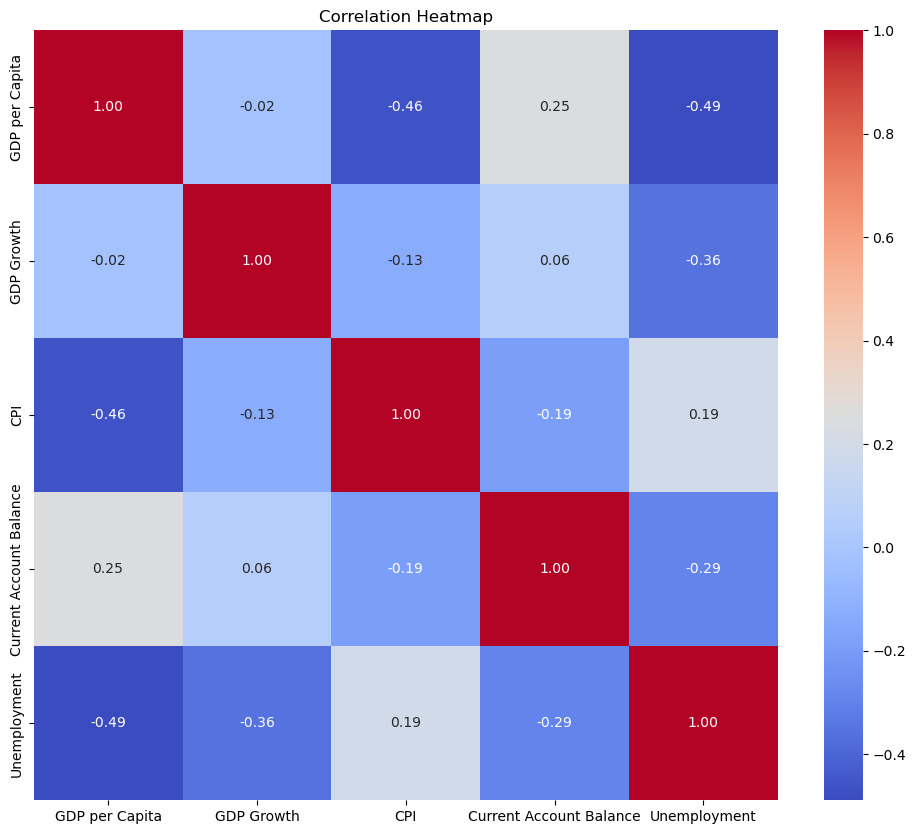

In [57]:
descriptive_stats(developed_df)

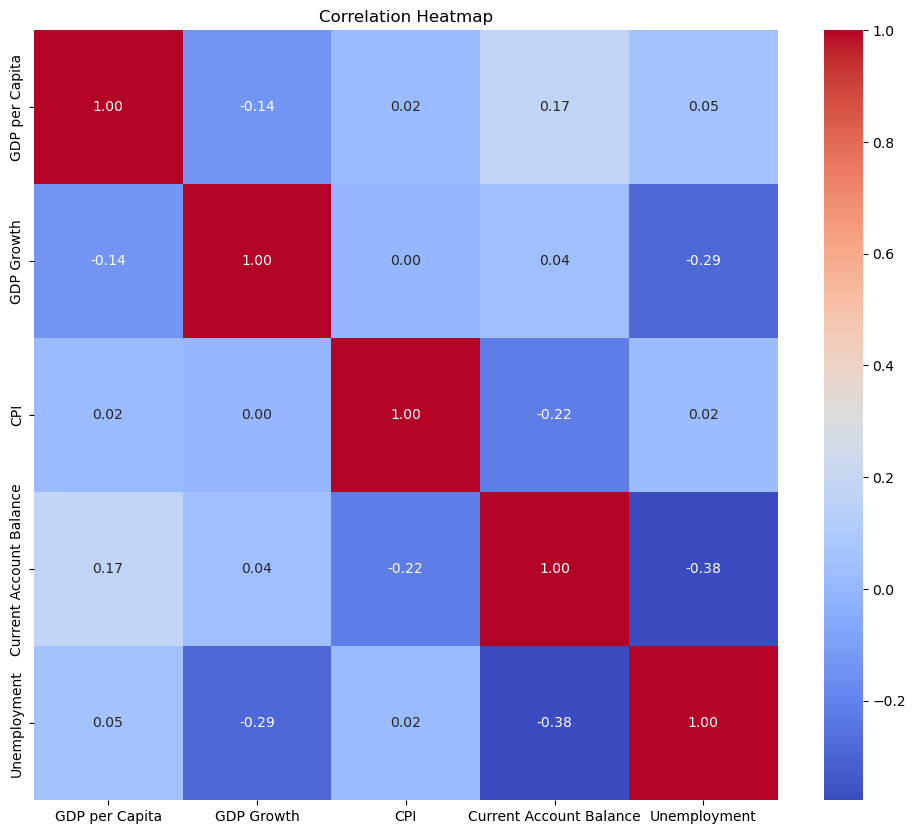

In [58]:
descriptive_stats(developing_df)

In [59]:
test_size = .25

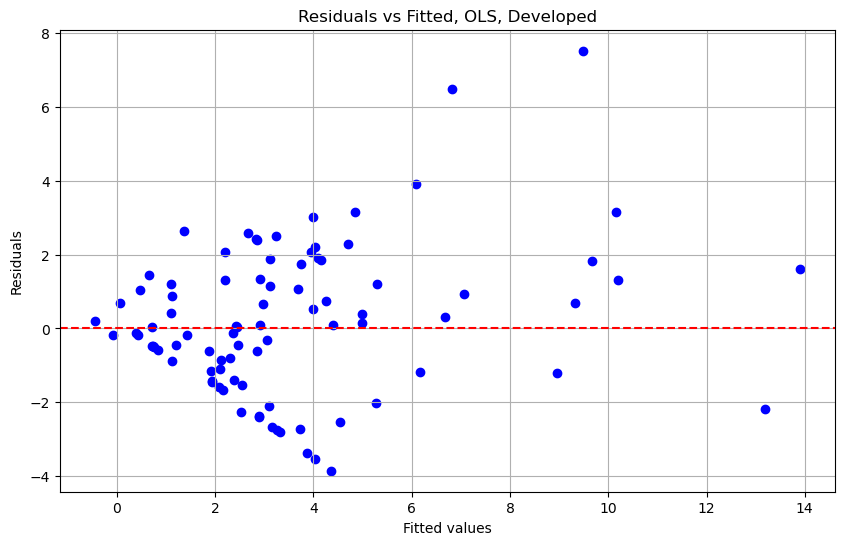

                            OLS Regression Results                            
Dep. Variable:          Interest Rate   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     157.7
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           2.63e-76
Time:                        15:42:44   Log-Likelihood:                -544.68
No. Observations:                 264   AIC:                             1101.
Df Residuals:                     258   BIC:                             1123.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [60]:
model_name = 'OLS, Developed'
y = developed_df['Interest Rate']
y = pd.to_numeric(y)
X = developed_df.drop(['Interest Rate','Country','Date_Quarterly'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Fit the OLS model
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
    
    # Make predictions on the test set
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)
residuals = y_test - y_pred
residuals_plot(y_pred, residuals, model_name)
    # Evaluate the model
mae= mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test,y_pred)
    # Print model summary and evaluation metrics
print(model.summary())
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print("Mean Squared Error:", mse)


In [61]:
ols_developed = model

In [62]:
model_name = 'Random Forest, Developed'
# Split data into train and test sets (10% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Set up Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objectiveRF, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params

# Train the model with the best hyperparameters
rf_best = RandomForestRegressor(**best_params, random_state=42)
rf_best.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_best.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test,y_pred)


print(f"Best Hyperparameters: {best_params}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print("Mean Squared Error:", mse)



[I 2024-04-13 15:42:44,272] A new study created in memory with name: no-name-11be864c-293e-4532-a025-92e8ee03d68a
[I 2024-04-13 15:42:46,829] Trial 0 finished with value: 3.0979810356208164 and parameters: {'n_estimators': 630, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 0 with value: 3.0979810356208164.
[I 2024-04-13 15:42:49,451] Trial 1 finished with value: 2.67485710637364 and parameters: {'n_estimators': 642, 'max_depth': 16, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 1 with value: 2.67485710637364.
[I 2024-04-13 15:42:50,143] Trial 2 finished with value: 2.381405481981535 and parameters: {'n_estimators': 193, 'max_depth': 28, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 2 with value: 2.381405481981535.
[I 2024-04-13 15:42:54,466] Trial 3 finished with value: 2.9945640029993985 and parameters: {'n_estimators': 978, 'max_depth': 5, 'min_sample

Best Hyperparameters: {'n_estimators': 414, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Mean Absolute Error (MAE): 0.67
Root Mean Squared Error (RMSE): 1.29
Mean Squared Error: 1.6716706310496319


c:\Users\aadit\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [63]:
rf_developed = rf_best

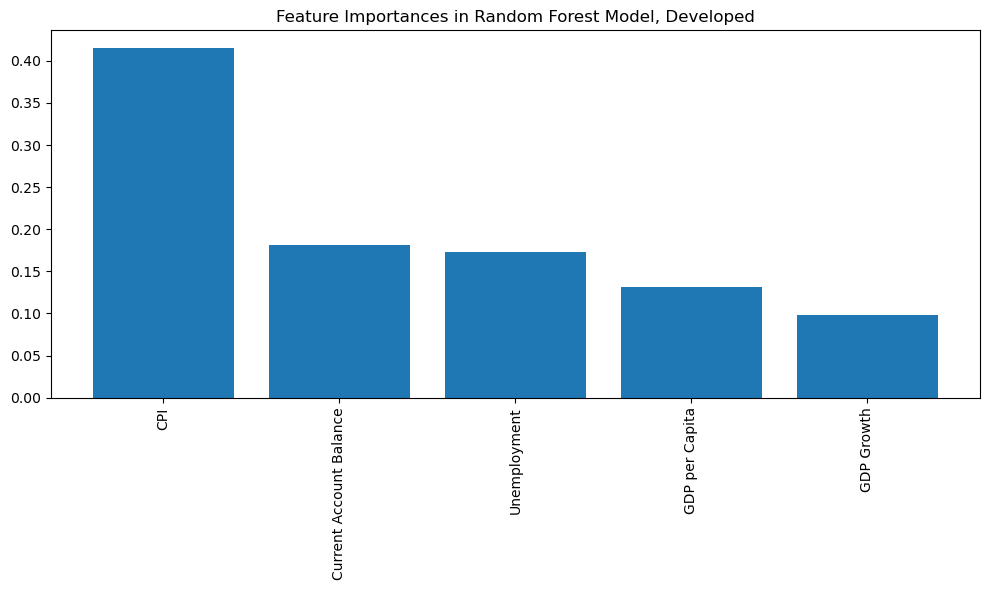

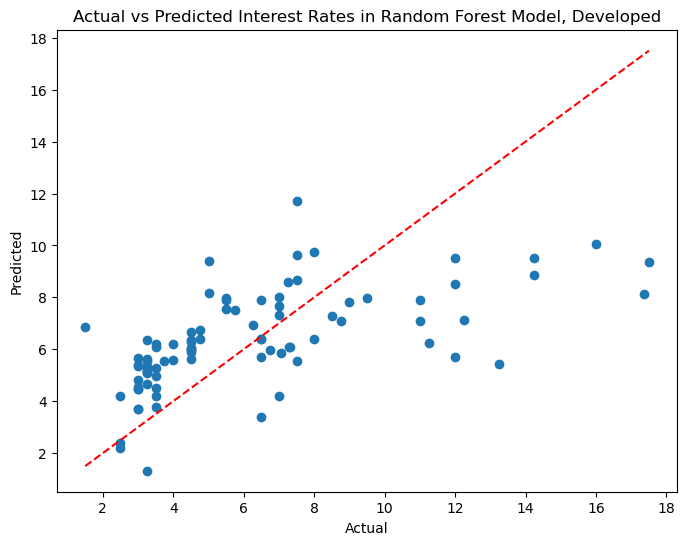

In [106]:
# Visualization: Feature Importance
feature_importances = rf_best.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances in Random Forest Model, Developed")
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

# Visualization: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Interest Rates in Random Forest Model, Developed')
plt.show()

In [65]:
def objectiveMLP(trial):
    # Define hyperparameters to be optimized
    hidden_layer_sizes = trial.suggest_int('hidden_layer_sizes', 1, 100)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic'])
    solver = trial.suggest_categorical('solver', ['sgd', 'adam', 'lbfgs'])
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-2)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])
    
    # Create MLP model with hyperparameters
    mlp = MLPRegressor(hidden_layer_sizes=(hidden_layer_sizes,),
                       activation=activation,
                       solver=solver,
                       alpha=alpha,
                       learning_rate=learning_rate,
                       random_state=42)
    
    # Train the model
    mlp.fit(X_train, y_train)
    
    # Calculate MSE on test set
    y_pred = mlp.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

In [66]:
model_name = 'MLP, Developed'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
# Create an Optuna study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objectiveMLP, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train the final model with the best hyperparameters
best_mlp = MLPRegressor(hidden_layer_sizes=(best_params['hidden_layer_sizes'],),
                        activation=best_params['activation'],
                        solver=best_params['solver'],
                        alpha=best_params['alpha'],
                        learning_rate=best_params['learning_rate'],
                        random_state=42)
best_mlp.fit(X_train, y_train)

# Evaluate the final model on test set
# Evaluate the model
y_pred = best_mlp.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test,y_pred)

print(f"Best Hyperparameters: {best_params}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print("Mean Squared Error:", mse)


[I 2024-04-13 15:44:29,322] A new study created in memory with name: no-name-9e122964-d749-4e09-9479-9ce101b24a53
C:\Users\aadit\AppData\Local\Temp\ipykernel_17276\816969768.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-2)
[I 2024-04-13 15:44:29,370] Trial 0 finished with value: 3.2900816669016e+27 and parameters: {'hidden_layer_sizes': 12, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.004608699671349689, 'learning_rate': 'constant'}. Best is trial 0 with value: 3.2900816669016e+27.
C:\Users\aadit\AppData\Local\Temp\ipykernel_17276\816969768.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.sug

Best hyperparameters: {'hidden_layer_sizes': 97, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 5.6810984351269915e-05, 'learning_rate': 'invscaling'}
Best Hyperparameters: {'hidden_layer_sizes': 97, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 5.6810984351269915e-05, 'learning_rate': 'invscaling'}
Mean Absolute Error (MAE): 1.54
Root Mean Squared Error (RMSE): 2.04
Mean Squared Error: 4.156716971803425


In [67]:
mlp_developed = best_mlp

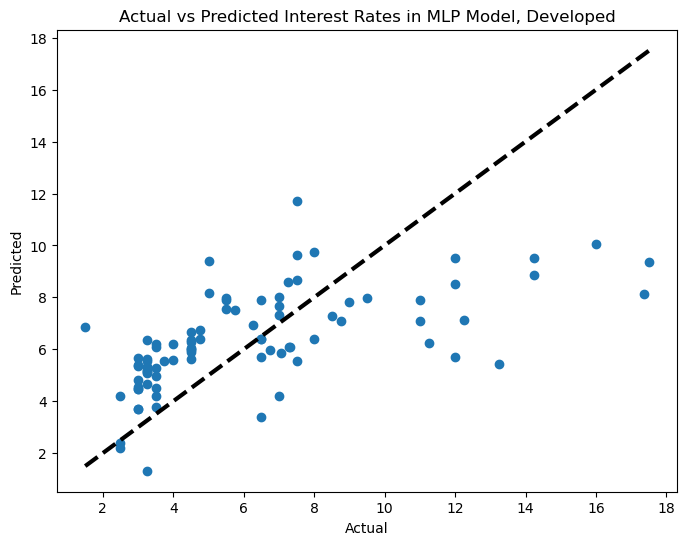

In [104]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Interest Rates in MLP Model, Developed')
plt.show()

# Calculate and print MSE

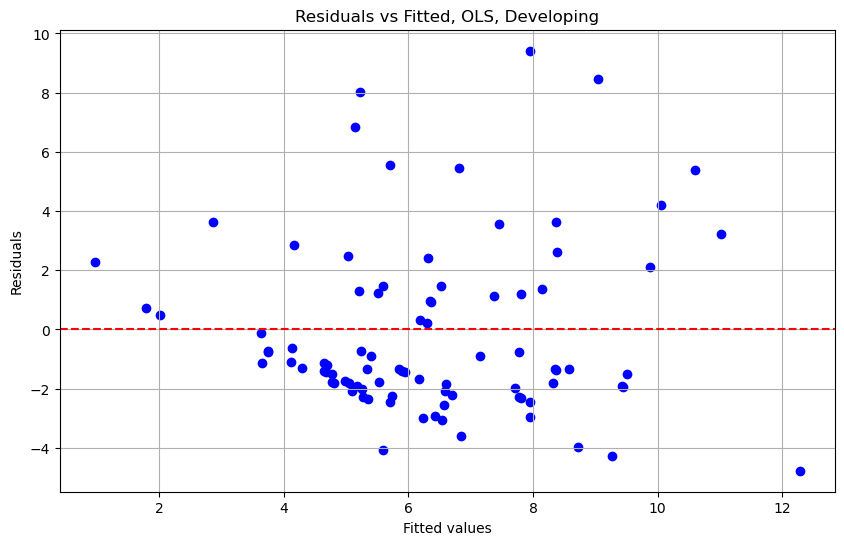

                            OLS Regression Results                            
Dep. Variable:          Interest Rate   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     38.22
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           2.79e-29
Time:                        15:45:05   Log-Likelihood:                -650.87
No. Observations:                 264   AIC:                             1314.
Df Residuals:                     258   BIC:                             1335.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [69]:
model_name = 'OLS, Developing'
y = developing_df['Interest Rate']
X = developing_df.drop(['Interest Rate','Country','Date_Quarterly'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Fit the OLS model
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
    
    # Make predictions on the test set
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)
residuals = y_test - y_pred
residuals_plot(y_pred, residuals, model_name)
    # Evaluate the model
mae= mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test,y_pred)

    # Print model summary and evaluation metrics
print(model.summary())
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print("Mean Squared Error:", mse)


In [70]:
ols_developing = model

In [71]:
# Split data into train and test sets (10% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Set up Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objectiveRF, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params

# Train the model with the best hyperparameters
rf_best = RandomForestRegressor(**best_params, random_state=42)
rf_best.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_best.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test,y_pred)


print(f"Best Hyperparameters: {best_params}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print("Mean Squared Error:", mse)


[I 2024-04-13 15:45:05,866] A new study created in memory with name: no-name-9258879a-46d7-4ad1-9ca6-6cf90f275d44
[I 2024-04-13 15:45:08,582] Trial 0 finished with value: 4.112193644644735 and parameters: {'n_estimators': 716, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 4.112193644644735.
[I 2024-04-13 15:45:12,401] Trial 1 finished with value: 2.012643922324945 and parameters: {'n_estimators': 907, 'max_depth': 23, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 2.012643922324945.
[I 2024-04-13 15:45:13,925] Trial 2 finished with value: 4.777692188842679 and parameters: {'n_estimators': 347, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 1 with value: 2.012643922324945.
[I 2024-04-13 15:45:16,859] Trial 3 finished with value: 2.731929118959573 and parameters: {'n_estimators': 751, 'max_depth': 28, 'min_samples

Best Hyperparameters: {'n_estimators': 764, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}
Mean Absolute Error (MAE): 0.78
Root Mean Squared Error (RMSE): 1.24
Mean Squared Error: 1.5369534929406585


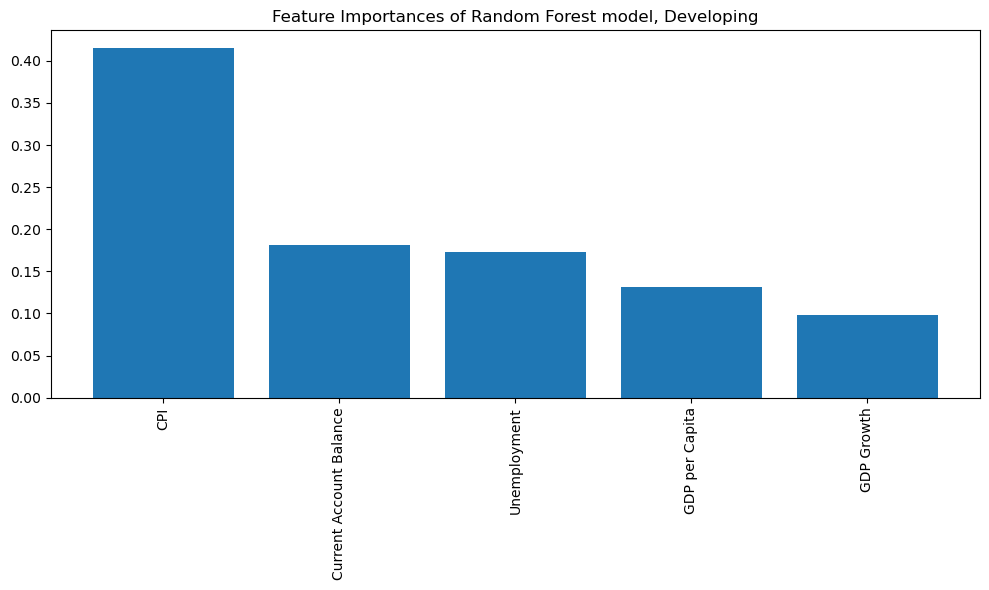

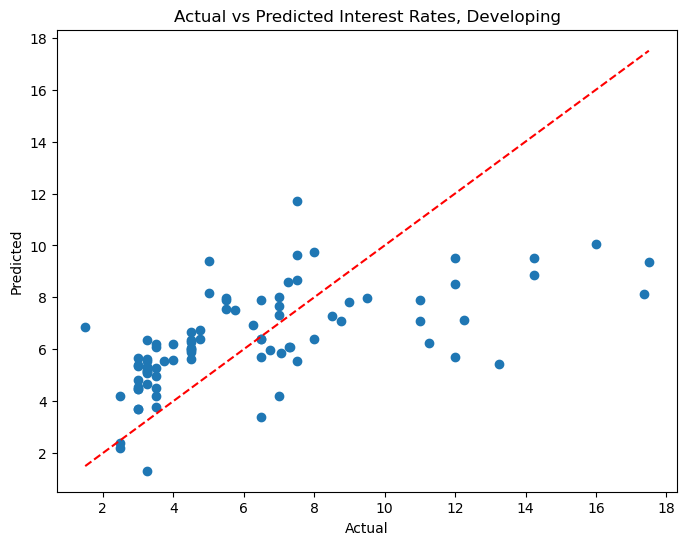

In [102]:
# Visualization: Feature Importance
feature_importances = rf_best.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances of Random Forest model, Developing")
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

# Visualization: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Interest Rates, Developing')
plt.show()

In [73]:
rf_developing = rf_best 

In [74]:
model_name = 'MLP, Developing'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
# Create an Optuna study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objectiveMLP, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train the final model with the best hyperparameters
best_mlp = MLPRegressor(hidden_layer_sizes=(best_params['hidden_layer_sizes'],),
                        activation=best_params['activation'],
                        solver=best_params['solver'],
                        alpha=best_params['alpha'],
                        learning_rate=best_params['learning_rate'],
                        random_state=42)
best_mlp.fit(X_train, y_train)

# Evaluate the final model on test set
# Evaluate the model
y_pred = best_mlp.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test,y_pred)

# Calculate the F1 score

print(f"Best Hyperparameters: {best_params}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print("Mean Squared Error:", mse)


[I 2024-04-13 15:47:43,990] A new study created in memory with name: no-name-b1936428-3604-465f-9544-91b6f0e49302


C:\Users\aadit\AppData\Local\Temp\ipykernel_17276\816969768.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-2)
c:\Users\aadit\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
[I 2024-04-13 15:47:44,341] Trial 0 finished with value: 8.643071785296328 and parameters: {'hidden_layer_sizes': 33, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 6.484413745329745e-05, 'learning_rate': 'adaptive'}. Best is trial 0 with value: 8.6430717852

Best hyperparameters: {'hidden_layer_sizes': 78, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.0022202736041089903, 'learning_rate': 'adaptive'}
Best Hyperparameters: {'hidden_layer_sizes': 78, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.0022202736041089903, 'learning_rate': 'adaptive'}
Mean Absolute Error (MAE): 2.27
Root Mean Squared Error (RMSE): 2.86
Mean Squared Error: 8.201230892437827


In [75]:
mlp_developing = best_mlp

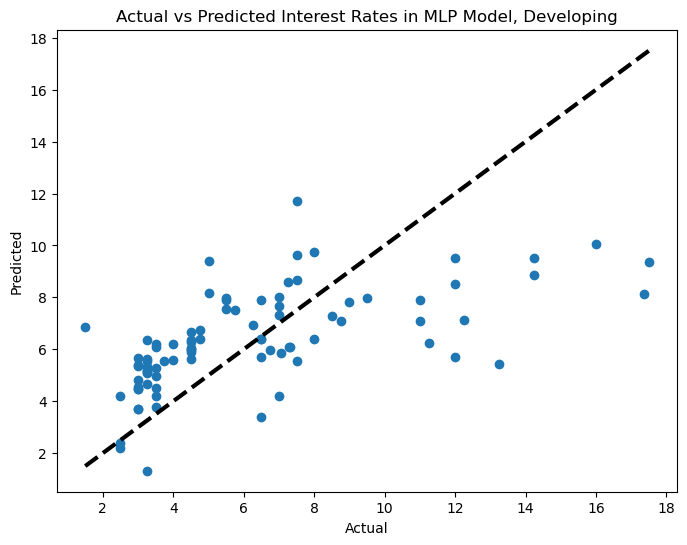

In [103]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Interest Rates in MLP Model, Developing')
plt.show()

# Calculate and print MSE
plt.show()

float64


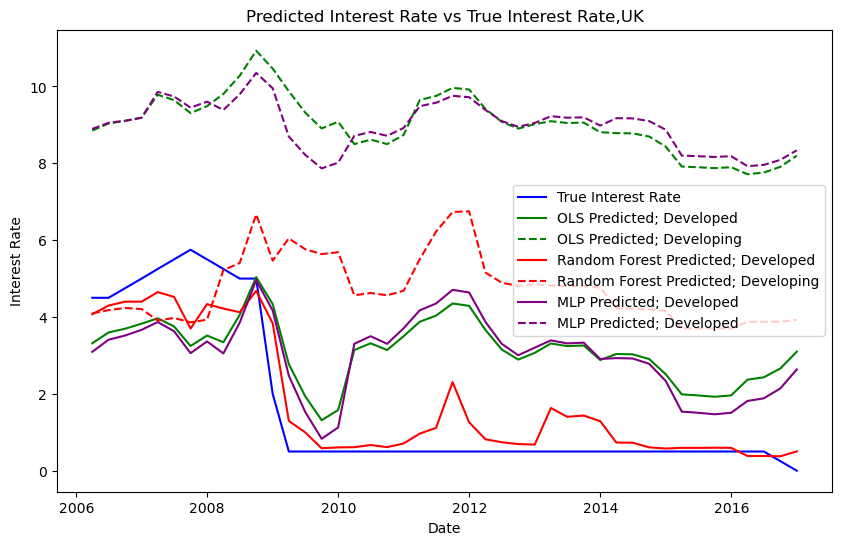

In [99]:
#time series viz
nation = 'UK'
print(developed_df['Interest Rate'].dtypes)
UK_df = developed_df.query('Country == "UK"')
UK_df.head()

X = UK_df.drop(['Interest Rate','Country','Date_Quarterly'], axis=1)

developed_rf_pred = rf_developed.predict(X)
developing_rf_pred = rf_developing.predict(X)
developed_mlp_pred = mlp_developed.predict(X)
developing_mlp_pred = mlp_developing.predict(X)

true_int = UK_df['Interest Rate']
X = sm.add_constant(X)
developed_ols_pred = ols_developed.predict(X)
developing_ols_pred = ols_developing.predict(X)


dates = UK_df['Date_Quarterly']  # Assuming 'Date_Quarterly' is your date column
plt.figure(figsize=(10, 6))
plt.plot(dates, true_int, label='True Interest Rate', color='blue')  # Plotting true interest rate

plt.plot(dates, developed_ols_pred, label='OLS Predicted; Developed', color='green')  # Plotting OLS predicted values
plt.plot(dates, developing_ols_pred, label='OLS Predicted; Developing', color='green', linestyle = 'dashed')  # Plotting OLS predicted values with developing model

plt.plot(dates, developed_rf_pred, label='Random Forest Predicted; Developed', color='red')  # Plotting RF predicted values
plt.plot(dates, developing_rf_pred, label='Random Forest Predicted; Developing', color='red', linestyle = 'dashed')  # Plotting RF predicted values with developing model

plt.plot(dates, developed_mlp_pred, label='MLP Predicted; Developed', color='purple')  # Plotting RF predicted values
plt.plot(dates, developing_mlp_pred, label='MLP Predicted; Developed', color='purple', linestyle = 'dashed')  # Plotting RF predicted values


plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.title(f'Predicted Interest Rate vs True Interest Rate,{nation}')
plt.legend()
plt.show()


float64


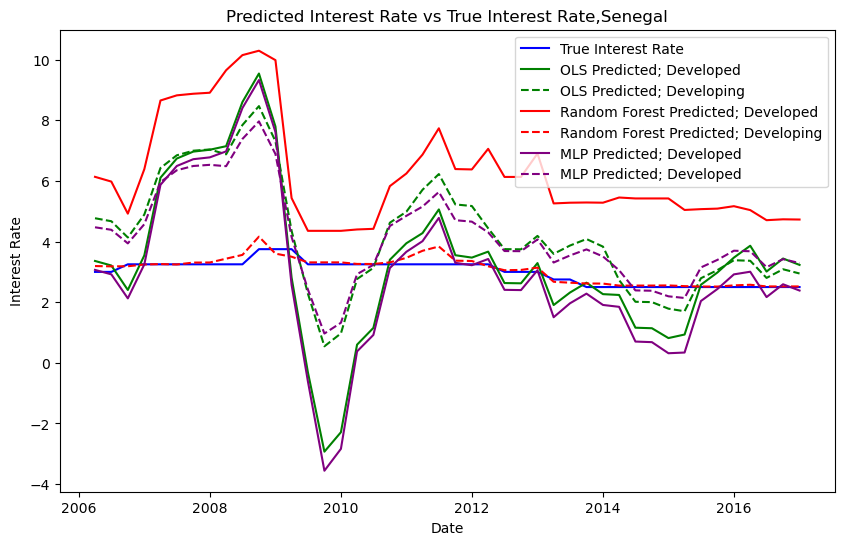

In [101]:
#time series viz
nation = 'Senegal'
print(developing_df['Interest Rate'].dtypes)
Senegal_df = developing_df.query('Country == "Senegal"')
Senegal_df.head()

X = Senegal_df.drop(['Interest Rate','Country','Date_Quarterly'], axis=1)

developed_rf_pred = rf_developed.predict(X)
developing_rf_pred = rf_developing.predict(X)
developed_mlp_pred = mlp_developed.predict(X)
developing_mlp_pred = mlp_developing.predict(X)

true_int = Senegal_df['Interest Rate']
X = sm.add_constant(X)
developed_ols_pred = ols_developed.predict(X)
developing_ols_pred = ols_developing.predict(X)


dates = Senegal_df['Date_Quarterly']  # Assuming 'Date_Quarterly' is your date column
plt.figure(figsize=(10, 6))
plt.plot(dates, true_int, label='True Interest Rate', color='blue')  # Plotting true interest rate

plt.plot(dates, developed_ols_pred, label='OLS Predicted; Developed', color='green')  # Plotting OLS predicted values
plt.plot(dates, developing_ols_pred, label='OLS Predicted; Developing', color='green', linestyle = 'dashed')  # Plotting OLS predicted values with developing model

plt.plot(dates, developed_rf_pred, label='Random Forest Predicted; Developed', color='red')  # Plotting RF predicted values
plt.plot(dates, developing_rf_pred, label='Random Forest Predicted; Developing', color='red', linestyle = 'dashed')  # Plotting RF predicted values with developing model

plt.plot(dates, developed_mlp_pred, label='MLP Predicted; Developed', color='purple')  # Plotting RF predicted values
plt.plot(dates, developing_mlp_pred, label='MLP Predicted; Developed', color='purple', linestyle = 'dashed')  # Plotting RF predicted values


plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.title(f'Predicted Interest Rate vs True Interest Rate,{nation}')
plt.legend()
plt.show()